In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import uuid

## Q1

In [2]:
filepath = 'data/names-'
baby_files = [
    'boys1952.txt',
    'girls1952.txt',
    'boys2001.txt',
    'girls2001.txt',
    'boys2002.txt',
    'girls2002.txt'
]

In [46]:
test = False

def str_trunc(f):
    return f"{f:.4f}"

cols = ['types', 'gender', 'counts']
for bf in baby_files:
    file_path = filepath + bf
    df = pd.read_csv(file_path,
                    names=cols)
    if test:
        df = df.head(1000)
    df['total_unique'] = df['types'].count()
    df['total'] = df['counts'].sum()
    df['probs'] = df['counts'] / df['total']
    # df['probs'] = df['probs_full'].map(str_trunc)
    df['ranks'] = df['counts'].rank(ascending=False)
    out_df = df[['types', 'counts', 'total_unique', 'probs']]
    out_df = out_df.sort_values(by='counts', ascending=False)
    if test:
        outpath = 'to_upload/test_' + bf[:-4] + '.csv'
    else:
        outpath = 'to_upload/' + bf[:-4] + '.csv'
    out_df.to_csv(outpath, index=False, sep=',')
    # print(out_df.head(100))

## Q2

In [23]:
def new_group_name():
    # create a random string as the group name
    return str(uuid.uuid4())

In [24]:
# Variable set up
rho = 0.001
max_timesteps = int(1000 / rho)  # the smaller rho is, the more timesteps you need to get 3 orders of magnitude
simulations = 1

In [25]:
## RHO = .01, ts = 100k, simul = 10. CPU times: user 1min 13s, sys: 1.24 s, total: 1min 14s
## RHO = .001, ts = 1m, simul = 10. CPU times: user 12min 23s, sys: 10.4 s, total: 12min 33s
# RHO = 0.1, ts = 100k, simul = 10. CPU times: user 9min 53s, sys: 16.2 s, total: 10min 9s

In [26]:
%%time
# We're averaging over given number of simulations to get better results
# del simulation_df  # don't keep old versions of simulation_df

for s in np.arange(0, simulations):
    
    # Save history for current simulation into groups
    groups = {}
    
    # Start with one group
    groups[new_group_name()] = 1
    
    # generate a probability for each timestep
    # (doing it once ahead of time, instead of 
    # doing it each step on the fly)
    random_number_array = np.random.rand(1, max_timesteps - 1)
    
    for t in np.arange(1, max_timesteps):
        # grab the random probability for this timestep
        curr_prob = random_number_array[0][t - 1]
    
        if curr_prob <= rho:
            # generate a new group
            # mutation / innovation
            groups[new_group_name()] = 1
            
        else:
            # with probability 1 - rho
            # replication / imitation

            # get a list of group ids
            existing_groups = list(groups.keys())

            # get the weight of each group
            # the value is the count/population of each group
            # t is the total population of groups bc we add 1 item per timestep
            existing_probs = list(groups.values()) /(t)
            
            # now make a weighted choice between existing groups
            # this next step is the really slow step
            # and it gets slower as rho gets bigger (more choices)
            # existing_choice = np.random.choice(existing_groups, 1, p = existing_probs)[0]
            existing_choice = random.choices(existing_groups, weights=existing_probs, k=1)[0]
            groups[existing_choice] += 1
    
    # turn the simulation run data into a dataframe
    group_df = pd.DataFrame(groups.items(), columns=['group_id', 'count'])
    group_df['simulation_run'] = s
    
    # Add the simulation run data into a full dataframe that captures multiple simulations
    try:
        simulation_df = pd.concat([simulation_df, group_df], ignore_index=True)
    except NameError:
        simulation_df = group_df

CPU times: user 1min 23s, sys: 1.49 s, total: 1min 25s
Wall time: 1min 26s


In [27]:
# simulation_df.head(200)

In [28]:
simulation_df['rank'] = simulation_df.groupby('simulation_run')['count'].rank(method='first', ascending=False)
# simulation_df.sort_values(by='rank', ascending=True).head(20)

In [29]:
# Average across rank (so we're averaging each simulation run across group rank)

def normalized(x):
    return math.ceil(x/simulations)

avg_df = simulation_df.groupby(['rank'])['count'].sum().reset_index(name='count')
avg_df['avg_count'] = avg_df['count'].map(normalized)
avg_df.head(200)


,rank,count,avg_count
0,1.0,990824,990824
1,2.0,1494,1494
2,3.0,959,959
3,4.0,917,917
4,5.0,528,528
...,...,...,...
195,196.0,4,4
196,197.0,4,4
197,198.0,4,4
198,199.0,4,4


In [30]:
# Create log columns
avg_df['log10_rank'] = np.log10(avg_df['rank'])
avg_df['log10_count'] = np.log10(avg_df['avg_count'])

In [31]:
pd.set_option('display.max_rows', None)
avg_df.sort_values(by='rank', ascending=True).head(200)

,rank,count,avg_count,log10_rank,log10_count
0,1.0,990824,990824,0.000000,5.995997
1,2.0,1494,1494,0.301030,3.174351
2,3.0,959,959,0.477121,2.981819
3,4.0,917,917,0.602060,2.962369
4,5.0,528,528,0.698970,2.722634
5,6.0,252,252,0.778151,2.401401
6,7.0,189,189,0.845098,2.276462
7,8.0,181,181,0.903090,2.257679
8,9.0,141,141,0.954243,2.149219
9,10.0,125,125,1.000000,2.096910


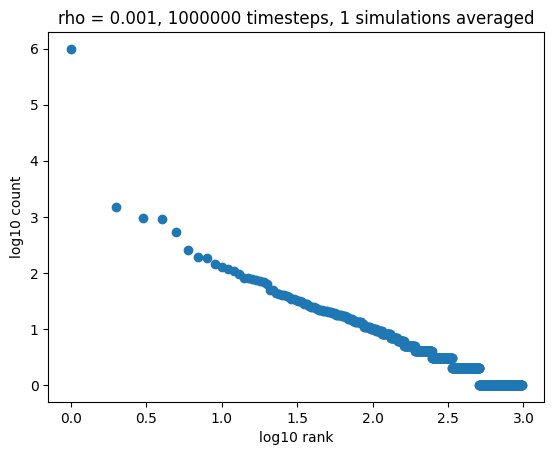

In [32]:
plt.title(f"rho = {rho}, {max_timesteps} timesteps, {simulations} simulations averaged")
plt.xlabel('log10 rank')
plt.ylabel('log10 count')
plt.scatter(avg_df['log10_rank'], avg_df['log10_count'])

In [38]:
# decide where you think the scaling regime is
# Same thing from assignment 4 where we had to do this
# min - max is just based on the log numbers from the x-axis of above graph
range = {"min": 1, "max": 2}

# fit a line for this scaling regime
scaling_range = avg_df[(avg_df['log10_rank'] < range["max"]) & (avg_df['log10_rank'] >= range["min"])]
X = sm.add_constant(scaling_range['log10_rank'])
line = sm.OLS(scaling_range['log10_count'], X).fit()
alpha = line.params.log10_rank
intercept = line.params.const
x_range = scaling_range['log10_rank']
y_range = scaling_range['log10_rank'] * alpha + intercept

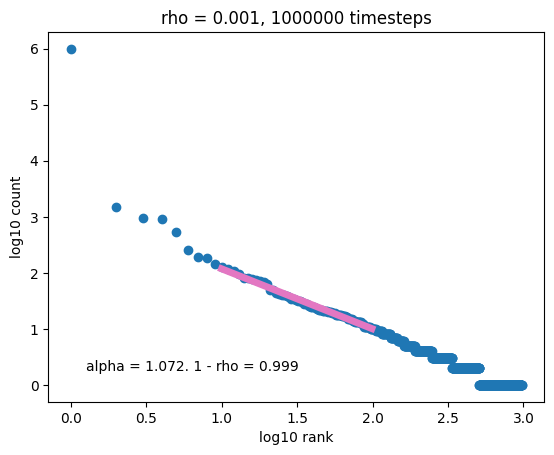

In [40]:
# Add fit line to the graph we have
plt.title(f"rho = {rho}, {max_timesteps} timesteps") #, {simulations} simulations averaged")
plt.xlabel('log10 rank')
plt.ylabel('log10 count')
plt.scatter(avg_df['log10_rank'], avg_df['log10_count'])
plt.plot(x_range, y_range, color="tab:pink", linewidth=5)
plt.text(0.1, 0.25, f"alpha = {alpha * -1:.3f}. 1 - rho = {1 - rho:.3f}")

plt.show()